# Prediction of the MACKAY GLASS Time Series

$y(n + 1) = y(n) -by(n) + \cfrac{cy(n-\tau)}{1+ y^{10} (n- \tau)}$, which is only defined for $n >= 18$

We consider a sample of 1000 elements and a set of sample of 500 samples for training.
Generate the data, plot it and analyse it.
Propose a Neural network based solution to predict this time serie and motivate your solution.

In [1]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import library to create the Neural Network model and evaluate it:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score,mean_squared_error

Mackay Glass function to generate the data of the time series

In [3]:
def MackayGlass (y, N):
    b = 0.1
    c = 0.2
    tau = 17
    for n in range(17, N):
        y = np.append(y, (y[n] - b*y[n] + (c*y[n-tau]/(1 + ((y[n-tau])**10)))))
    return(y)

In [4]:
#18 first values of the time series:
y_list = [0.96, 0.96, 0.97, 1.0, 1.03, 1.07, 1.10, 1.13, 1.14, 1.14, 1.13, 1.12, 1.10, 1.09, 1.08, 1.07, 1.07, 1.07]

#generate all the data with the function:
Y_from_list=pd.DataFrame()
Y_from_list = MackayGlass(y_list, 999)
print(Y_from_list.shape)

(1000,)


Plot the function with the sample of 1000 elements of the data generated.

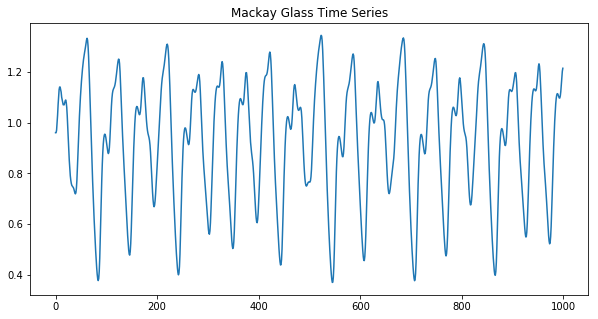

In [5]:
plt.figure(figsize=(10,5))
plt.plot(Y_from_list)
plt.title('Mackay Glass Time Series')
plt.show()

The first step is to load the data generated and create a lagged representation. 
the observation at t-1 is for training the model and  the observation at t+1 is for making prediction.

In [6]:
# Create lagged dataset
values = pd.DataFrame(Y_from_list)

#put the values of t-1 at the first column and t+1 at the second column
lag=pd.concat([values.shift(1), values],axis=1)
lag.columns = ['t-1', 't+1']
print(lag.head(5))

    t-1   t+1
0   NaN  0.96
1  0.96  0.96
2  0.96  0.97
3  0.97  1.00
4  1.00  1.03


split the lag data for a training set of 0 at 500 elements , and split the lag data of 500 to 1000 for the prediction and the evaluation.

In [9]:
# split into training set: X_train, y_train
X_train=np.array(lag['t-1'][1:500]).reshape(-1,1)
y_train=np.array(lag['t+1'][1:500]).reshape(-1,1)

#Split into testing set: X_test, y_test
X_test=np.array(lag['t-1'][500:]).reshape(-1,1)
y_test=np.array(lag['t+1'][500:]).reshape(-1,1)
print(X_train.shape)
print(X_test.shape)

(499, 1)
(500, 1)


The MLPRegressor implements a multi-layer perceptron (MLP) that trains using backpropagation with no activation function in the output layer,I choose 1 hidden layers of 5 neurons, I choose the activation 'identity':no-op activation, useful to implement linear bottleneck, returns f(x) = x and the solver 'lbfgs':is an optimizer in the family of quasi-Newton methods. With these parameters for the data, the model converge easily to the minimum. I train the model with the training set of 0 at 500 samples.

In [10]:
# Create MPL regressor
model=MLPRegressor(hidden_layer_sizes=(5),activation='identity',solver='lbfgs',random_state=1)

#ravel(y_train,order=C)-style order, with the last axis index changing fastest, 
#back to the first axis index changing slowest
model.fit(X_train,np.ravel(y_train,order='C'))



MLPRegressor(activation='identity', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

Evaluate the model with predictions for the test data:

In [12]:
#generate the predictions data thanks to the model trained
y_pred=[]
for i in range(0,(X_test.shape[0])):
    pred = model.predict(X_test[i].reshape(1,-1))
    y_pred = y_pred +[pred]

#print(y_pred)

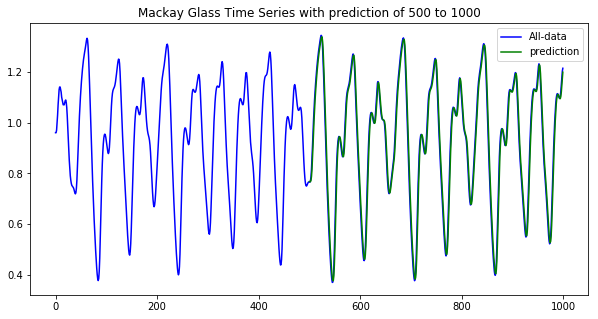

In [16]:
# Plot the data predict with the entire data
plt.figure(figsize=(10,5))
plt.plot(Y_from_list,color='blue')
plt.plot(range(500,1000), y_pred,color='g')
plt.title('Mackay Glass Time Series with prediction of 500 to 1000')
plt.legend(['All-data', 'prediction'])
plt.show()


As you can see the data predict in green fit perfectly with the data of 500 to 1000. With an accuracy score of 95.8%

In [21]:
#accuracy score of the model
y_test=y_test.astype('int')
y_pred = np.array(y_pred) 
y_pred=y_pred.astype('int')
print('the accuracy score is:',accuracy_score(y_test, y_pred))

the accuracy score is: 0.958


# Mean squared error regression loss

Mean Square Error (MSE) is the most commonly used regression loss function. MSE is the sum of squared distances between our target variable and predicted values.

In [23]:
#calculation of the prediction error with mean squared error metrics
#print('MSE : ',(np.sum((y_pred-y_test)**2)/500))
print('MSE:', (mean_squared_error(y_test,y_pred)))

MSE: 0.042


The MSE is low, the sum of squared distances between our y_test and predicted values is good.

# Average relative variance :

In [24]:
#print('ARV is:',explained_variance_score(y_test, y_pred, multioutput='uniform_average'))

ARV=((np.sum((y_pred-y_test)**2)/500)/(np.sum(y_pred-(np.mean(y_test))**2)/1000))
print('the ARV is',ARV)

the ARV is 0.34215885947046853


# DEBUGGING ALGORITHM:

# learning curves

this diagnostic tools, can help us to improve the performance of a learning algorithm. By plotting the model training and validation accuracies as functions of the training set size, we can easily detect whether the model suffers from high variance or high bias.

In [25]:
#import library for generating the learning curves
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr=make_pipeline(StandardScaler(),LogisticRegression(penalty='l2',random_state=1))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

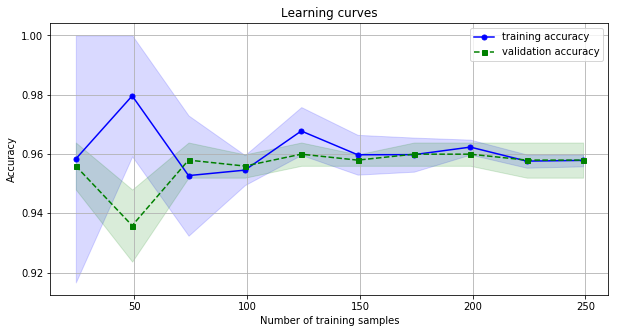

In [27]:
y_train=y_train.astype('int')

train_sizes, train_scores, test_scores=learning_curve(estimator=pipe_lr,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1.0,10),cv=2,n_jobs=1)

train_mean=np.mean(train_scores,axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores,axis=1)
test_std=np.std(test_scores,axis=1)

plt.figure(figsize=(10,5))
#calculate the average accuracies from the returned cross-validated training scores for the different size of the training set
plt.plot(train_sizes,train_mean,color='b',marker='o',markersize=5,label='training accuracy')
#variance of the estimate:standard deviation of the training average accuracy 
plt.fill_between(train_sizes,train_mean + train_std, train_mean - train_std,alpha=0.15, color='blue')
#calculate the average accuracies from the returned cross-validated test scores for the different size of the training set
plt.plot(train_sizes, test_mean, color='green',linestyle='--', marker='s',markersize=5,label='validation accuracy')
#variance of the estimate:standard deviation of the validation average accuracy 
plt.fill_between(train_sizes,test_mean + test_std, test_mean - test_std,alpha=0.15, color='green')

plt.grid()
plt.title('Learning curves')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
#plt.ylim([0.6,0.9])
plt.show()

the model has a good bias-variance trade off